# 识别手写数字0-9

In [182]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [183]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


##softmax识别手写数字原理

#1.mnist数据集分析
   训练数据输入 mnist.train.images(55000,784),标签数据(55000,10)
   数据说明：每一张图片的大小都是28*28，将其展开成一个一维行向量（共784个值，有原来28*28图片数组的每一行组成）
   对于标签数据，将0~9共10个数字使用独热编码展开为10维，即0展开为[1,0,0,0,0,0,0,0,0,0],1展开为[0,1,0,0,0,0,..]
#2.softmax多分类原理
    其实这个多分类原理很简单，路程如下图所示：
    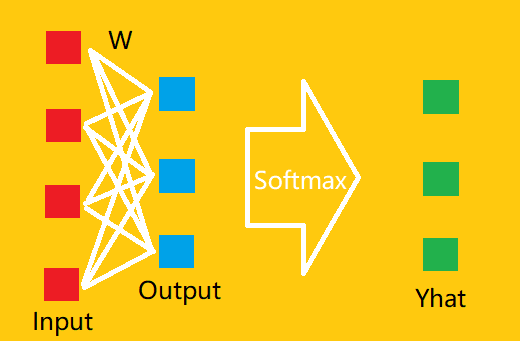
    红色代表输入X，每一个都是一个图片向量，通过权重W和偏置b做一个线性变换W*x+b得到蓝色输出。举例说明：
    假设其中一张图片的一维向量是[0,0.1,0.5],laibels为【1,2,3】，也就是将这个图片分为其中的一类，那么线性变换为：
    [0,0.1,0.5]*[[w1,w2,w3],[w4,w5,w6],[w7,w8,w9]],这里x为（1,3），w为（3*3），那么w为什么为这个形状呢？3行是必须的，为什么是3列呢？因为有3个标签。现在总结一下，由于输入x为（1，3），如果是多个图片则x为（n，3），w的形状为（3，3）相乘得到（n，3），因此b的形状为（n，3），得到的最终的一个线性变换后的矩阵为L（n，3），每一行表示一个输入x的转换结果，每一列对应一个类别。  

以上，就完成了线性变化，还没有提到softmax。就拿最终L矩阵的第一行来说，它表示第一个实例（输入）的转换结果，那么他到底属于哪一类呢？这个就该softmax出场了，假设L的第一列为[z1,z2,z3],按照softmax公式，如下图：
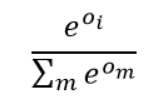
m表示类别数，这里为3，针对[z1,z2,z3]，简单点理解，通过变换就可以等价于[z1/sum,z2/sum,z3/sum]的结果，做指数变换其实是为了让‘大的更大’其中sum=z1+z2+z3,这里就完成了soft，max就是找到[z1/sum,z2/sum,z3/sum]-->[e**(z1)/e**(sum),e**(z2)/e**(sum),e**(z3)/e**(sum)]中三个数最大的，假设为e**(z1)/e**(sum)，这将该输入x分为‘1’类。

接下来就是通过tensorflow去将这些原理实现。
    

In [184]:
#占位符,模型的输入参数x，形状为[n,784],因为训练数据是一个55000*784的矩阵
x = tf.placeholder(dtype=tf.float32,shape=[None,784],name='input')
#实际的y标签
y = tf.placeholder(dtype=tf.float32,shape=[None,10],name='labels')

#构建模型，Y = W*x+b
#定义权重和偏置变量
W = tf.Variable(tf.zeros([784,10]), name = 'W')
b = tf.Variable(tf.zeros([1,10]), name = 'b')
Y = tf.add(tf.matmul(x, W), b)
y_pred = tf.nn.softmax(Y)

In [228]:
# 使用交叉熵计算损失
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred),reduction_indices = [1]))

#loss = -tf.reduce_sum(y * tf.log(y_pred))
# 使用反向传播算法进行模型训练
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

# 创建会话，并且初始化全部变量
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)


# 迭代执行训练操作
for i in range(1000):
    # 每次从训练数据中随机选取100个样本，构成一个mini-batch
    batch_xs, batch_ys = mnist.train.next_batch(100)
    #train_step.run({x: mnist.train.next_batch(100)[0], y: mnist.train.next_batch(100)[1]})
    sess.run(train,{x: batch_xs, y: batch_ys})

# 计算模型在训练集中的分类精度    
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
#检查tf.argmax()效果
print(sess.run(tf.argmax(y_pred, 1),feed_dict={x: mnist.test.images}))
print(sess.run(tf.argmax(y, 1),feed_dict={y: mnist.test.labels}))
print(sess.run(tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1)),feed_dict={x: mnist.test.images,y: mnist.test.labels}))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# 计算模型在测试集中的分类精度
print(accuracy.eval({x: mnist.test.images, y:mnist.test.labels}))

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
[ True  True  True ...  True  True  True]
0.9189
